### Black-Scholes Model
In this notebook I'm going to demonstrate some simple functions for modelling an equity (stock) price, as well as the price of a European options contract with this equity as the underlying, according to the Black-Scholes model. 

Further I will demonstrate two approximation methods which are useful for when the Black-Scholes equations cannot be solved. One method is a Monte-Carlo method, where the payoff is approximated by the mean of many simulations. The second method is a Cox-Ross-Rubinstein binomial tree method, which is a discrete time approximation to the continuous case.

#### Equity Model
In the Black-Scholes world an equity priced $S_t$ at time $t$ follows the stochastic differential equation (SDE)

$ dS_t = \mu S_t dt + \sigma S_t d W_t $

where $\mu$ is the trend, $\sigma$ is the volatility, and $W_t$ is a Brownian motion. This can be re-written as follows

$ S_T = S_t \exp((\mu-\frac{1}{2}\sigma^2)(T-t) + \sigma (W_T - W_t)). $

After choosing values for $\mu$ and $\sigma$, it suffices to model a Brownian motion to get a model of the equity price. As such the first step is to model a Brownian motion.

Recall the defining properties of a Brownian motion $\{W_t\}_{t\in [0,T]}$ are that $W_0 = 0$ almost surely, $W_{t_i} - W_{t_{i-1}}$ are pairwise independent for $t_1 < t_2 < \ldots < t_n$ for each $i$, the sample paths $W_t$ are continuous, and most importantly for our purposes $W_t - W_s$ is Gaussian with mean zero, variance $t-s$ for each $s<t$. As such we can create a discrete model of a Brownian motion as a cumulative sum of samples from a Gaussian distribution.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal

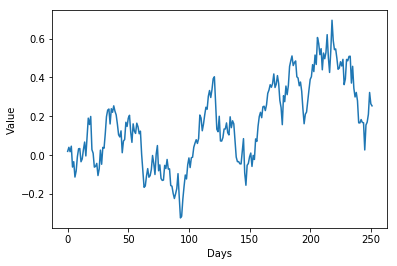

In [38]:
def brownian_motion(years, plot = False):
    ''' Creates a discrete Brownian motion by daily samples.
        With plot=True a graph of the motion is also produced.''' 
    N = years*252
    t = np.linspace(0, years, N)
    dt = 1/252
    W = np.random.normal(scale = np.sqrt(dt), size = N)
    W = np.cumsum(W)
    if(plot):
        plt.plot(np.arange(N),W)
        plt.xlabel("Days")
        plt.ylabel("Value")
        plt.show()
    return W
W = brownian_motion(1, plot=True)

Note that I am using the standard 252 market days of the year here as the sample times. 

Using this we can easily compute the simulated evolution of an equity. Note that in the following the trend and volatility are annualised, and written as decimals, i.e. 1% is 0.01.

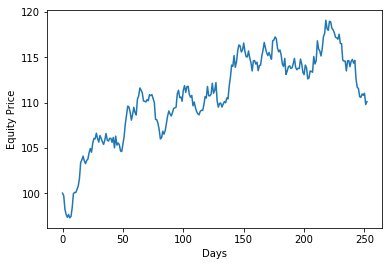

In [43]:
def equity_price(years, initial_price=100, trend=0.01, volatility = 0.1, plot=False):
    ''' Simulated the evolution of an equity for a number of days,
        with initial price, trend and volatility given.
        With plot=True, a plot of the equity price evolution is produced.'''
    W = brownian_motion(years, plot=False)
    t = np.linspace(0, years, years*252)
    X = (trend - (volatility**2)/2)*t + volatility*W
    # Insert initial price at start of sequence.
    S = np.insert(initial_price * np.exp(X), 0,initial_price)
    if(plot):
        # If plotting, need to also insert t=0 in the sample times t.
        plt.plot(np.arange(years*252+1),S)
        plt.xlabel("Days")
        plt.ylabel("Equity Price")
        plt.show()
    return S
S = equity_price(1,100,0.01,0.1,True)

### European Call Option Price
In the case of a European call option the Black-Scholes equations can be solved in a number of ways to arrive at the formula 

$C(t, S_t) = S_t N(d_1) - K \exp (-r (T-t)) N(d_2) $

where $N(x)$ is the cumulative distribution function of the standard Gaussian, $K$ is the strike price of the option, $r$ is the risk-free interest rate, and 

$d_i = (\sigma^2 (T-t))^{-\frac{1}{2}} \left( \log(\frac{S_t}{K}) + (r - (-1)^i \frac{\sigma^2}{2}) (T-t) \right)$

This can be easily computed given just $S_t, K, r$ and $\sigma$.

In [81]:
def eu_call_option_price(years, initial_price=100, strike_price=100, risk_free_rate=0.01, volatility=0.1):
    ''' Computes the Black-Scholes price of a European call option.'''
    d_factor = np.power((volatility**2)*years, -0.5)
    d_log = np.log(initial_price/strike_price)
    d_r_term = (risk_free_rate + (volatility**2)/2)*years
    d1 = d_factor * (d_log + d_r_term)
    d2 = d1 - volatility* np.sqrt(years)
    exp_factor = np.exp(-risk_free_rate*years)
    from scipy.stats import norm
    C = initial_price * norm.cdf(d1) - strike_price*exp_factor*norm.cdf(d2)
    return C
C = eu_call_option_price(1,100,100,0.05, 0.01)
print(C)

4.877057602069669


### Monte-Carlo Approximation
The method of Monte-Carlo approximation is to estimate a stochastic value by taking the mean of many simulated outcomes of a process. A standard example is to run the following process many times. Choose values $x_i,y_i \in [0,1]$ uniformly for each simulation $i=1, \ldots, N$, where $N$ is some large number. Then let $p$ denote the fraction $\frac{n}{N}$ where $n$ is the number of simulations for which $x_i ^2 + y_i ^2 \leq 1$. Geometrically, this is the fraction of $(x_i, y_i)$ lying in the unit circle. Geometric intuition (and formally, measure theory) implies that $p$ is equal to the ratio of the area of the circle with radius $\frac{1}{2}$, i.e.  $\frac{\pi}{4}$ to the area of the unit square $1$. 

In the case of options pricing, the output value is the payoff of the options contract. We can evaluate this for each simulation of the equity price evolution, and take the mean of the payoffs to get the price of the contract.

In [101]:
def monte_carlo_price(years, num_simulations = 10000, initial_price=100,  strike_price = 100, volatility=0.01, risk_free_rate = 0.01):
    payoff = 0.0
    for i in range(num_simulations):
        prices = equity_price(years=1, initial_price=initial_price, trend=risk_free_rate, volatility=volatility)
        payoff += np.exp(-risk_free_rate*years)*np.maximum(0,prices[-1]-strike_price)
    return payoff/num_simulations
print(monte_carlo_price(years=1,num_simulations = 10000,initial_price = 100, strike_price = 100,volatility = 0.01, risk_free_rate = 0.05))

4.8610403444414745


Note that the trend of the equity has been replaced by the risk free rate here. We can see how Monte-Carlo approximation converges by tracking the error over a number of different simulation lengths.

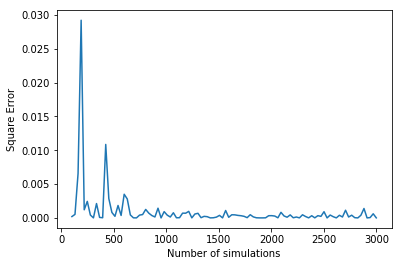

In [112]:
# Note this cell can take a while if you increase the num_samples too high, or the max-number of simulations.
num_samples = 100
simulation_lengths = np.linspace(100,3000, num_samples)
C = eu_call_option_price(1,100,100,0.05, 0.01)
errors = np.zeros(num_samples)
for i in range(num_samples):
    errors[i] = C - monte_carlo_price(years=1,num_simulations = int(simulation_lengths[i]),initial_price = 100, strike_price = 100,volatility = 0.01, risk_free_rate = 0.05)
plt.plot(simulation_lengths, np.power(errors,2))
plt.xlabel("Number of simulations")
plt.ylabel("Square Error")
plt.show()

One use of Monte-Carlo approximation is when there is not an analytic formula for the option price. One such example is a barrier option. The payoff structure here is the same as a call option if the barrier price is not hit, but drops to 0 if the barrier is hit. To check this we simply need to check the equity price throughout it's evolution.

In [140]:
def barrier_option_payoff(years=1, initial_price = 100, strike_price = 100, barrier = 105.5, risk_free_rate = 0.05, volatility = 0.01):
    prices = equity_price(years = years, initial_price = initial_price, volatility = volatility, trend = risk_free_rate)
    barrier_hit = False
    payoff = 0
    for price in prices:
        if price > barrier:
            barrier_hit = True
            break
    if not barrier_hit:
        payoff = np.exp(-risk_free_rate * years) * np.maximum(0, prices[-1]-strike_price)
    return payoff

5.1818409526269456


In [214]:
def monte_carlo_barrier_price(years, num_simulations = 1000, initial_price=100,  strike_price = 100, barrier = 105.5, volatility=0.01, risk_free_rate = 0.05):
    payoff = 0.0
    for i in range(num_simulations):
        payoff += barrier_option_payoff(years=years, initial_price = initial_price, strike_price = strike_price, 
                                        barrier = barrier, risk_free_rate = risk_free_rate, volatility = volatility)
    return payoff/num_simulations
print(monte_carlo_barrier_price(years = 1, num_simulations = 3000, initial_price = 100, strike_price = 100, barrier = 105.5, volatility = 0.01, risk_free_rate = 0.05))

2.7026984310002966


To check this works we can set the barrier unreasonably high, in which case the usual European call price should be recovered.

In [152]:
print(monte_carlo_barrier_price(years = 1, num_simulations = 5000, initial_price = 100, strike_price = 100, barrier = 1000, volatility = 0.01, risk_free_rate = 0.05))

4.870625979064586


### Binomial Tree Approximation
Another approximation is to the Black-Scholes model for the price of an option is the Cox-Ross-Rubinstein binomial tree method. Here we build a recombinant binomial tree to model the equity price. Each step forward represents a discrete step forward in time, the equity price can either rise or fall. 

In fact we have that $S_{t+1} = u S_t$ or $S_{t+1} = d S_t$ where $d = 1/u$. This final equality is what allows the tree to be recombinant. 

We can store the tree as a Python dictionary. At each time step the dictionary will return another dictionary, parameterised by the number of upward steps taken so far, and returning the value of $S_t$ in this case. In other words

$S_t = u^k d^{t-k} S_0 = u^{2k - t} S_0$ for any $k=0, 1, \ldots, t$. 

In [158]:
def build_tree(initial_price, up_multiplier, num_steps):
    ''' Returns a Cox-Ross-Rubinstein binomial tree stored
        as a dictionary, mapping each time step to another dictionary,
        storing the possible equity prices at this time.'''
    down_multiplier = 1/float(up_multiplier)
    if num_steps == 0:
        tree = {}
        tree[0] = {}
        tree[0][0] = initial_price
        return tree
    else:
        tree = build_tree(initial_price, up_multiplier, num_steps-1)
        tree[num_steps] = {}
        for num_ups in tree[num_steps-1]:
            tree[num_steps][num_ups] = down_multiplier*tree[num_steps-1][num_ups]
            tree[num_steps][num_ups+1] = up_multiplier*tree[num_steps-1][num_ups]
        return tree
tree = build_tree(initial_price=100,up_multiplier = 1.1, num_steps = 4)
print(tree[0])
print(tree[1])
print(tree[2])
print(tree[3])

{0: 100}
{0: 90.9090909090909, 1: 110.00000000000001}
{0: 82.64462809917354, 1: 100.00000000000001, 2: 121.00000000000003}
{0: 75.13148009015777, 1: 90.90909090909092, 2: 110.00000000000003, 3: 133.10000000000005}


The method is now to apply the payoff function at each node of the tree, and discount according to the time step. We will test this with the European call option payoff function first.

In [160]:
def eu_call_payoff(price, strike):
    if price>strike:
        return price-strike
    else:
        return 0
payoffs = []
for i in tree[3]:
    payoffs.append(eu_call_payoff(tree[3][i], strike = 100))
print(payoffs)

[0, 0, 10.000000000000028, 33.10000000000005]


If the up multiplier is $u$, the down multiplier $d$, and the discount rate $\exp(-r)$ then one can compute the risk-free probability $q$ of the equity going from $S_t$ to $S_{t+1} = uS_t$ as follows. One has that $S_{t}$ is a martingale under the risk-free probability and so

$ S_t = E_q (\exp(-r) S_{t+1}) = \exp(-r) \left(q u S_t + (1-q) d S_t\right).$

It is immediately clear we can divide through by $S_t$ and solve to find 

$ q = (\exp(r) - d)/(u-d) $.

In the Cox-Ross-Rubinstein model we use that $u = \exp(\sigma \sqrt{t})$.

Using these we can build a new tree from the equity price tree that contains the payoff of the call option at each node.

In [165]:
# helper functions

# discount function
def discount(rate=1, dt=1):
    return np.exp(-rate*dt)

# risk free probability of up movement
def risk_free_prob(rate, up, dt = 1, dividend = 0):
    down = 1/float(up)
    r = (rate - dividend)*dt
    return (np.exp(r)-down)/(up - down)

def up_multiplier(sigma, time):
    return np.exp(sigma*np.sqrt(time))

In [212]:
def price_tree(tree, prob, strike, payoff, rate, dt, discount):
    price_tree = {}
    n = len(tree)-1
    price_tree[n] = {}
    for j in range(n+1):
        price_tree[n][j] = payoff(tree[n][j],strike)
    for i in range(1,n+1):
        j = n-i
        price_tree[j] = {}
        for k in range(j+1):
            price_tree[j][k] = (1-prob)*(price_tree[j+1][k])+ prob*(price_tree[j+1][k+1])
            price_tree[j][k] = discount(rate,dt)*price_tree[j][k]
    return price_tree

rate=0.05
num_steps = 1000
dt = 1/num_steps
sigma = 0.01
up = up_multiplier(sigma, dt)
initial_price = 100

tree = build_tree(initial_price, up, num_steps)
prob = risk_free_prob(rate, up, dt)
strike = 100
call_tree = price_tree(tree, prob, strike, eu_call_payoff, rate, dt, discount)
print(call_tree[0])

{0: 4.877057593320787}


We can also validate the Monte-Carlo approximation of the barrier option price by the binomial tree method.

In [215]:
def barrier_payoff(price, strike, barrier=105.5):
    if price > strike and price < barrier:
        return price-strike
    else:
        return 0

rate=0.05
num_steps = 1000
dt = 1/num_steps
sigma = 0.01
up = up_multiplier(sigma, dt)
initial_price = 100

tree = build_tree(initial_price, up, num_steps)
prob = risk_free_prob(rate, up, dt)
strike = 100
call_tree = price_tree(tree, prob, strike, barrier_payoff, rate, dt, discount)
print(call_tree[0])

{0: 2.738865948504003}
